In [26]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential                                                            # Importing all the required Libraries
from keras import layers
from keras.layers import Conv2D,MaxPool2D, Dense, Dropout, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizer_v2.adam import Adam
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras import Model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import numpy as np 
import cv2
import os

import warnings                                                                                # Removing all those annoying Warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [27]:
training_gen=ImageDataGenerator(rescale=1./255)                                                                                    # Creating Image generators, for all train, validation, and test set
validation_gen=ImageDataGenerator(rescale=1./255)
testing_gen=ImageDataGenerator(rescale=1./255)

In [28]:
train_gen_3ch=training_gen.flow_from_directory('archive/train',                                # Creating  Training Dataset with 3 channels for plotting it and check the labelling
                                           target_size=(48,48),
                                           batch_size=32,
                                           class_mode='categorical')
train_gen=training_gen.flow_from_directory('archive/train',                                    # Creating  Training Dataset 
                                           target_size=(48,48),
                                           batch_size=32,
                                           color_mode='grayscale',
                                           class_mode='categorical')
valid_gen=validation_gen.flow_from_directory('archive/validation',                             # Creating Validation Set
                                           target_size=(48,48),
                                           batch_size=32,
                                           color_mode='grayscale',
                                           class_mode='categorical')
test_gen=testing_gen.flow_from_directory('archive/test',                                        # Creating Test Set
                                           target_size=(48,48),  
                                           batch_size=32,
                                           color_mode='grayscale',
                                           class_mode='categorical',
                                           shuffle= False) 

Found 28207 images belonging to 7 classes.
Found 28207 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 502 images belonging to 7 classes.


In [29]:
print(train_gen.class_indices) 

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


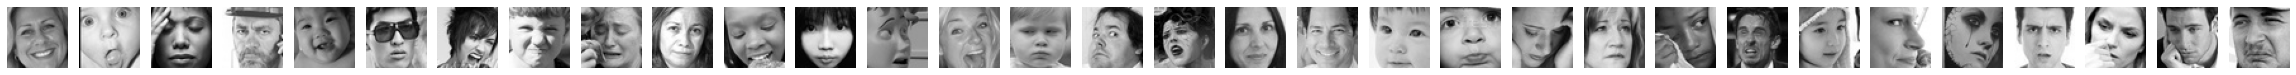

happy   surprise   neutral   angry   happy   neutral   angry   angry   sad   neutral   happy   neutral   fear   happy   sad   fear   sad   happy   happy   happy   neutral   sad   fear   sad   angry   neutral   angry   sad   surprise   sad   sad   disgust   

In [30]:
imgs,lables=next(train_gen_3ch)                                                                                                     # Extracting next batch to plot it, this batch of photos are selected randomly
list_of_keys=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']                                                    # list of Classes
def plotImages(images_arr):
  fig, axes= plt.subplots(1,32,figsize=(32,2))
  axes= axes.flatten()
  for img, ax in zip(images_arr,axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()
plotImages(imgs)
for i in lables[:32]:                                                                                                              # Printing the lables below the respective image
  for num, j in enumerate(i):
    if j==1:
      print(list_of_keys[num], end='   ')                                                                                          # Labelling seems to be spot on     
num+=1   

In [31]:
cnn_model= Sequential([                                                                                                             # Using Keras Sequential model to build out CNN
    Conv2D(32, kernel_size=(3,3), activation='relu',input_shape=(48,48,1)),                                                         # First Layer of convolutional Nural network, input shape is provided only at this instance.
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),                                                                                                     # Maxpool Layer
    Dropout(0.05),

    Conv2D(128, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.05),
    
    Conv2D(256, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.05), 
    
    Conv2D(512, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.05), 
    
    Flatten(),                                                                                                                      # Flattening out all the layers
    Dense(1024, activation='relu'),
    Dense(7, activation='softmax')]
)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 128)       0

In [32]:
checkpoint = ModelCheckpoint('./my_model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping=EarlyStopping(monitor='val_loss',
                            min_delta=0.1,
                            patience=4,
                            verbose=2,
                            restore_best_weights=True)
decay_lr= ReduceLROnPlateau(monitor='val_loss',
                           factor=0.2,
                           patience=3,
                           verbose=1,
                           min_delta=0.0001)
callbacks=[early_stopping,checkpoint,decay_lr]

In [33]:
cnn_model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])                                           # Compiling the Model
cnn_model.fit(train_gen, epochs=20, verbose=2,validation_data=valid_gen, callbacks=callbacks)  

Epoch 1/20
882/882 - 186s - loss: 1.7513 - accuracy: 0.2793 - val_loss: 1.5645 - val_accuracy: 0.3835
Epoch 2/20
882/882 - 131s - loss: 1.4599 - accuracy: 0.4289 - val_loss: 1.3645 - val_accuracy: 0.4710
Epoch 3/20
882/882 - 130s - loss: 1.2926 - accuracy: 0.5008 - val_loss: 1.2440 - val_accuracy: 0.5228
Epoch 4/20
882/882 - 130s - loss: 1.1842 - accuracy: 0.5460 - val_loss: 1.1845 - val_accuracy: 0.5460
Epoch 5/20
882/882 - 130s - loss: 1.1053 - accuracy: 0.5818 - val_loss: 1.1593 - val_accuracy: 0.5538
Epoch 6/20
882/882 - 131s - loss: 1.0353 - accuracy: 0.6094 - val_loss: 1.1470 - val_accuracy: 0.5596
Epoch 7/20
882/882 - 131s - loss: 0.9697 - accuracy: 0.6333 - val_loss: 1.1301 - val_accuracy: 0.5747
Epoch 8/20
882/882 - 131s - loss: 0.9109 - accuracy: 0.6581 - val_loss: 1.1307 - val_accuracy: 0.5819
Epoch 9/20
882/882 - 130s - loss: 0.8440 - accuracy: 0.6821 - val_loss: 1.1769 - val_accuracy: 0.5804
Epoch 10/20
882/882 - 130s - loss: 0.7884 - accuracy: 0.7049 - val_loss: 1.1951 - 

In [34]:
cnn_model.fit(train_gen, epochs=20, verbose=2,validation_data=valid_gen, callbacks=callbacks)  

Epoch 1/20
882/882 - 127s - loss: 1.1059 - accuracy: 0.5787 - val_loss: 1.1630 - val_accuracy: 0.5456
Epoch 2/20
882/882 - 130s - loss: 1.0645 - accuracy: 0.5947 - val_loss: 1.1484 - val_accuracy: 0.5603
Epoch 3/20
882/882 - 130s - loss: 1.0218 - accuracy: 0.6115 - val_loss: 1.1403 - val_accuracy: 0.5685
Epoch 4/20
882/882 - 130s - loss: 0.9779 - accuracy: 0.6292 - val_loss: 1.1339 - val_accuracy: 0.5680
Epoch 5/20
882/882 - 128s - loss: 0.9315 - accuracy: 0.6479 - val_loss: 1.1431 - val_accuracy: 0.5759
Restoring model weights from the end of the best epoch.
Epoch 00005: early stopping


In [35]:
history=cnn_model.history.history
for i in history.keys():
  print(i)

loss
accuracy
val_loss
val_accuracy
lr


In [36]:
predictions=cnn_model.predict(test_gen)
from sklearn.metrics import confusion_matrix, classification_report
cm=confusion_matrix(y_pred=np.argmax(predictions, axis=-1), y_true=test_gen.classes)
cm

array([[42,  1,  5,  9,  8,  8,  2],
       [30,  8, 11, 10,  1, 13,  2],
       [ 6,  0, 10,  2,  2,  8,  4],
       [ 0,  0,  3, 67,  2,  7,  1],
       [10,  0, 10, 13, 23, 20,  4],
       [10,  1,  6,  7, 11, 44,  1],
       [ 0,  0,  6,  6,  1,  2, 65]], dtype=int64)

In [37]:
from sklearn.metrics import accuracy_score
aoc=accuracy_score(y_pred=np.argmax(predictions, axis=-1),y_true=test_gen.classes)
aoc                                                                   # I am able to get an accuracy of only 50% lets try with a pretrained model

0.5159362549800797

In [34]:
cnn_model.save('my_model.h5')

# Now I will use Pre-trained MobileNet Model to see if accuracy can be improved or not 

In [2]:
data_dir='archive/train/'

In [3]:
# for cat in classes:
#     path=os.path.join(data_dir,cat)
#     path=os.path.join(data_dir_valid,cat)
#     path=os.path.join(data_dir_test,cat)

In [4]:
'''As Mobile Net Takes Input array of shape (None,224,224,3) i will change the shape of my sets accordingly'''
classes=['angry','disgust','fear','happy','neutral','sad','surprise']
temp_set=[]
def createset(data_dir=data_dir):
    for cat in classes:
        path=os.path.join(data_dir,cat)
        class_num=classes.index(cat)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array, (224,224))
                temp_set.append([new_array,class_num])
            except Exception as e:
                pass

In [5]:
createset(data_dir)
train_set=temp_set
print(len(train_set))

28207


In [6]:
import random
random.shuffle(train_set)

In [7]:
X=[]
y=[]
for features, lables in train_set:
    X.append(features)
    y.append(lables)
X=np.array(X).reshape(-1,224,224,3)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_validation,y_train, y_validation= train_test_split(X,y,test_size=0.1)

In [9]:
model=tf.keras.applications.MobileNetV2()                         # Importing MobileNet Model

In [10]:
model.summary()                                                   # In Model Summary, We can that it can Classify 1000 object 

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [11]:
base_input=model.layers[0].input

In [12]:
base_input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [13]:
base_output=model.layers[-2].output

In [14]:
base_output

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>

In [15]:
final_output=layers.Dense(128)(base_output)
final_output=layers.Activation('relu')(final_output)
final_output=layers.Dense(128)(final_output)
final_output=layers.Activation('relu')(final_output)
final_output=layers.Dense(7, activation='softmax')(final_output)

In [16]:
final_output

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'dense_2')>

In [17]:
final_model=keras.Model(inputs=base_input, outputs=final_output)

In [18]:
for layer in final_model.layers[:-23]:
    layer.trainable = False

In [19]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [20]:
# checkpoint = ModelCheckpoint('./my_model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# early_stopping=EarlyStopping(monitor='val_loss',
#                             min_delta=0.1,
#                             patience=4,
#                             verbose=2,
#                             restore_best_weights=True)
# decay_lr= ReduceLROnPlateau(monitor='val_loss',
#                            factor=0.2,
#                            patience=3,
#                            verbose=1,
#                            min_delta=0.0001)
# callbacks=[early_stopping,checkpoint,decay_lr]

In [21]:
from tensorflow.keras.utils import to_categorical
X_train=np.array(X_train).reshape(-1, 224,224,3)
y_train=to_categorical(np.array(y_train),7)
X_validation=np.array(X_validation).reshape(-1, 224,224,3)
y_validation=to_categorical(np.array(y_validation),7)

In [22]:
final_model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001), metrics=['accuracy'])       # Compiling the Model
final_model.fit(X_train,y_train, epochs=20, verbose=2,validation_data=(X_validation, y_validation),batch_size=32)  

Epoch 1/20
794/794 - 406s - loss: 1.5786 - accuracy: 0.3765 - val_loss: 2.2255 - val_accuracy: 0.1581
Epoch 2/20
794/794 - 401s - loss: 1.3411 - accuracy: 0.4864 - val_loss: 2.0981 - val_accuracy: 0.2233
Epoch 3/20
794/794 - 401s - loss: 1.1818 - accuracy: 0.5559 - val_loss: 2.3961 - val_accuracy: 0.2205
Epoch 4/20
794/794 - 401s - loss: 1.0205 - accuracy: 0.6248 - val_loss: 1.7945 - val_accuracy: 0.3559
Epoch 5/20
794/794 - 403s - loss: 0.8426 - accuracy: 0.6978 - val_loss: 1.5884 - val_accuracy: 0.4325
Epoch 6/20
794/794 - 406s - loss: 0.6698 - accuracy: 0.7661 - val_loss: 1.8180 - val_accuracy: 0.4403
Epoch 7/20
794/794 - 400s - loss: 0.5158 - accuracy: 0.8242 - val_loss: 1.9420 - val_accuracy: 0.4172
Epoch 8/20
794/794 - 396s - loss: 0.3797 - accuracy: 0.8767 - val_loss: 2.0276 - val_accuracy: 0.4537
Epoch 9/20
794/794 - 396s - loss: 0.2783 - accuracy: 0.9123 - val_loss: 2.0764 - val_accuracy: 0.4782
Epoch 10/20
794/794 - 394s - loss: 0.2056 - accuracy: 0.9379 - val_loss: 2.5549 - 

# Here model is overfitting our training set, and thus we are able to get an accuracy of 97.33% on training data while just 44.13 % on validation data

In [25]:
# cnn_model.save('my_model.h5')
final_model.save('transfer_learning_model.h5')